# Tensor Networks Assignment 2025/26
### Mar López

In this assignement, we are going to study the real-time evolution of the transverse-field Ising model in a one-dimensional spin-1/2 chain with open boundary conditions. The Hamiltonian that describes this model is
$$
H_{Ising}(g) = \sum_{i=1}^{N-1}X_iX_{i+1} + g \sum_i^N Z_i \quad .
$$

The goal is to compute the expectation value of the local operator $Z_{i=N/2}(t)$ using two different tensor-network contraction strategies: 

- Standard real-time evolution with MPS (TEBD).
- Spatial contraction of the corresponding tensor network.

First, we can import the modules we are going to use.

In [1]:
import numpy as np
import scipy.linalg as LA
import matplotlib.pyplot as plt
import matplotlib
from ncon import ncon
np.set_printoptions(precision=5, suppress=True, linewidth=100)
plt.rcParams['figure.dpi'] = 150

In [2]:
import tenpy
import tenpy.linalg.np_conserved as npc
from tenpy.algorithms import tebd
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain

tenpy.tools.misc.setup_logging(to_stdout="INFO")

## Part I: Expectation value with TEBD

In this section, we compute the expectation value of the local operator $Z_{i=N/2}(t)$ up to time $T=5$ using TEBD (Time Evolving Block Decimation). TEBD is an algorithm for simulating the time evolution of one-dimensional quantum many-body systems represented as Matrix Product States (MPS).

To do so, we will use and adapt the TEBD example provided by TenPy: [A first TEBD Example](https://tenpy.readthedocs.io/en/v1.0.4/notebooks/00_tebd.html).

### Model Setup and Initialization

First, we set up the initial parameters for the TEBD simulation. We define a chain of length $L = 50$ spins and create a TFIChain model with coupling strength $J = 1.0$ and transverse field $g = 0.7$.

In [3]:
N = 50
g = 0.7
T = 4.0
dt = 0.1
chi_max = 100

In [4]:
model_params = {
    'J': 1. ,
    'g': g ,
    'L': N ,
    'bc_MPS': 'finite',
}

M = TFIChain(model_params)

INFO    : TFIChain: reading 'bc_MPS'='finite'
INFO    : TFIChain: reading 'L'=50
INFO    : TFIChain: reading 'J'=1.0
INFO    : TFIChain: reading 'g'=0.7


With the chosen model, we build the initial state `psi` as a product-state MPS on the lattice `M.lat`.
The list `[['up']]` means every site starts in the local state $\ket{\uparrow}$, so the initial state is $\ket{\uparrow\uparrow\uparrow...\uparrow}$.

In [5]:
psi = MPS.from_lat_product_state(M.lat, [['up']])

Then, we set the TEBD parameters (time step, Trotter order) and the truncation settings that control the maximum bond dimension and discarded singular values. 

We also create the TEBD engine that evolves `psi` with the model `M` using the previous parameters.

In [6]:
tebd_params = {
    'N_steps': 1,
    'dt': dt,
    'order': 2,
    'trunc_params': {'chi_max': chi_max, 'svd_min': 1.e-12}
}

eng = tebd.TEBDEngine(psi, M, tebd_params)

INFO    : TEBDEngine: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')


### Measurement and data collection

To analyze the real-time dynamics of the system, we need to extract physical observables from the evolving MPS state. We define a `measurement` function that systematically records key quantities at each time step. The observables we measure are:

- Entanglement entropy: reveals how quantum correlations grow as the system evolves far from equilibrium.
- Local magnetization: ($\langle \sigma_x \rangle$, $\langle \sigma_z \rangle$) provides insight into the expectation values of individual operators.
- Correlations: ($\langle \sigma_x^i \sigma_x^j \rangle$) characterize how information spreads across the chain.
- Truncation error: monitors the numerical accuracy of our MPS approximation throughout the evolution.

The `measurement` function is called at each time step to build a comprehensive dataset that we later analyze and visualize.

In [7]:
def measurement(eng, data):
    """Collect observables from the current TEBD state.
    Args:
        eng: TEBD engine with the current MPS state.
        data: dict of lists or None (initialized if None).
    Returns:
        data: dict with time, entropy, magnetization, correlations, and truncation error.
    """
    keys = ['t', 'entropy', 'Sx', 'Sz', 'corr_XX', 'corr_ZZ', 'trunc_err']
    if data is None:
        data = dict([(k, []) for k in keys])
    data['t'].append(eng.evolved_time)
    data['entropy'].append(eng.psi.entanglement_entropy())
    data['Sx'].append(eng.psi.expectation_value('Sigmax'))
    data['Sz'].append(eng.psi.expectation_value('Sigmaz'))
    data['corr_XX'].append(eng.psi.correlation_function('Sigmax', 'Sigmax'))
    data['corr_ZZ'].append(eng.psi.correlation_function('Sigmaz', 'Sigmaz'))
    data['trunc_err'].append(eng.trunc_err.eps)
    return data

In [8]:
data = measurement(eng, None)
while eng.evolved_time < T:
    eng.run()
    measurement(eng, data)

INFO    : TEBDEngine: reading 'dt'=0.1
INFO    : TEBDEngine: reading 'N_steps'=1
INFO    : TEBDEngine: reading 'order'=2
INFO    : Calculate U for {'order': 2, 'delta_t': 0.1, 'type_evo': 'real', 'E_offset': None, 'tau': 0.1}
INFO    : trunc_params: reading 'chi_max'=100
INFO    : trunc_params: reading 'svd_min'=1e-12
INFO    : --> time=0.100 + 0.000j, max(chi)=4, max(S)=0.05577, avg DeltaS=5.5553e-02, since last update: 1.0s
INFO    : --> time=0.200 + 0.000j, max(chi)=6, max(S)=0.16365, avg DeltaS=1.0752e-01, since last update: 0.9s
INFO    : --> time=0.300 + 0.000j, max(chi)=8, max(S)=0.28594, avg DeltaS=1.2197e-01, since last update: 0.5s
INFO    : --> time=0.400 + 0.000j, max(chi)=9, max(S)=0.40207, avg DeltaS=1.1593e-01, since last update: 0.6s
INFO    : --> time=0.500 + 0.000j, max(chi)=10, max(S)=0.50082, avg DeltaS=9.8668e-02, since last update: 0.5s
INFO    : --> time=0.600 + 0.000j, max(chi)=12, max(S)=0.57815, avg DeltaS=7.7336e-02, since last update: 0.6s
INFO    : --> time

### Results: Observable Dynamics During Time Evolution

To analyze the TEBD simulation results, we visualize four key observables that characterize the system's evolution from the initial product state $\ket{\uparrow\uparrow...\uparrow}$:

- Entanglement Entropy (top-left): Shows the von Neumann entropy $S = -\text{Tr}(\rho\log\rho)$ at the center bond (site $N/2$). The increase of entropy indicates the growth of quantum correlations as the system evolves from the initially separable product state.

- Total Magnetization (top-right): Tracks the total magnetization $\sum_i\langle\sigma_x^i\rangle$ (blue) and $\sum_i\langle\sigma_z^i\rangle$ (orange) across all sites. The decay from the initial values reveals how the system moves away from the $\ket{\uparrow}$ product state as quantum dynamics mix the spin configurations. The Z-magnetization starts at its maximum value (all spins up) and oscillates while decreasing.

- Spatial Correlations (bottom-left): Displays two-point correlation functions $\langle X_i X_j\rangle$ as a function of the site. Different curves (color-coded by time) show how correlations spread spatially.

- Truncation Error (bottom-right): Monitors the discarded weight from SVD truncation at each time step. The low values (typically $<10^{-10}$) confirm that our maximum bond dimension $\chi_{\max}=200$ provides highly accurate results throughout the evolution. Sudden increases in truncation error indicate moments when the quantum state becomes more entangled.

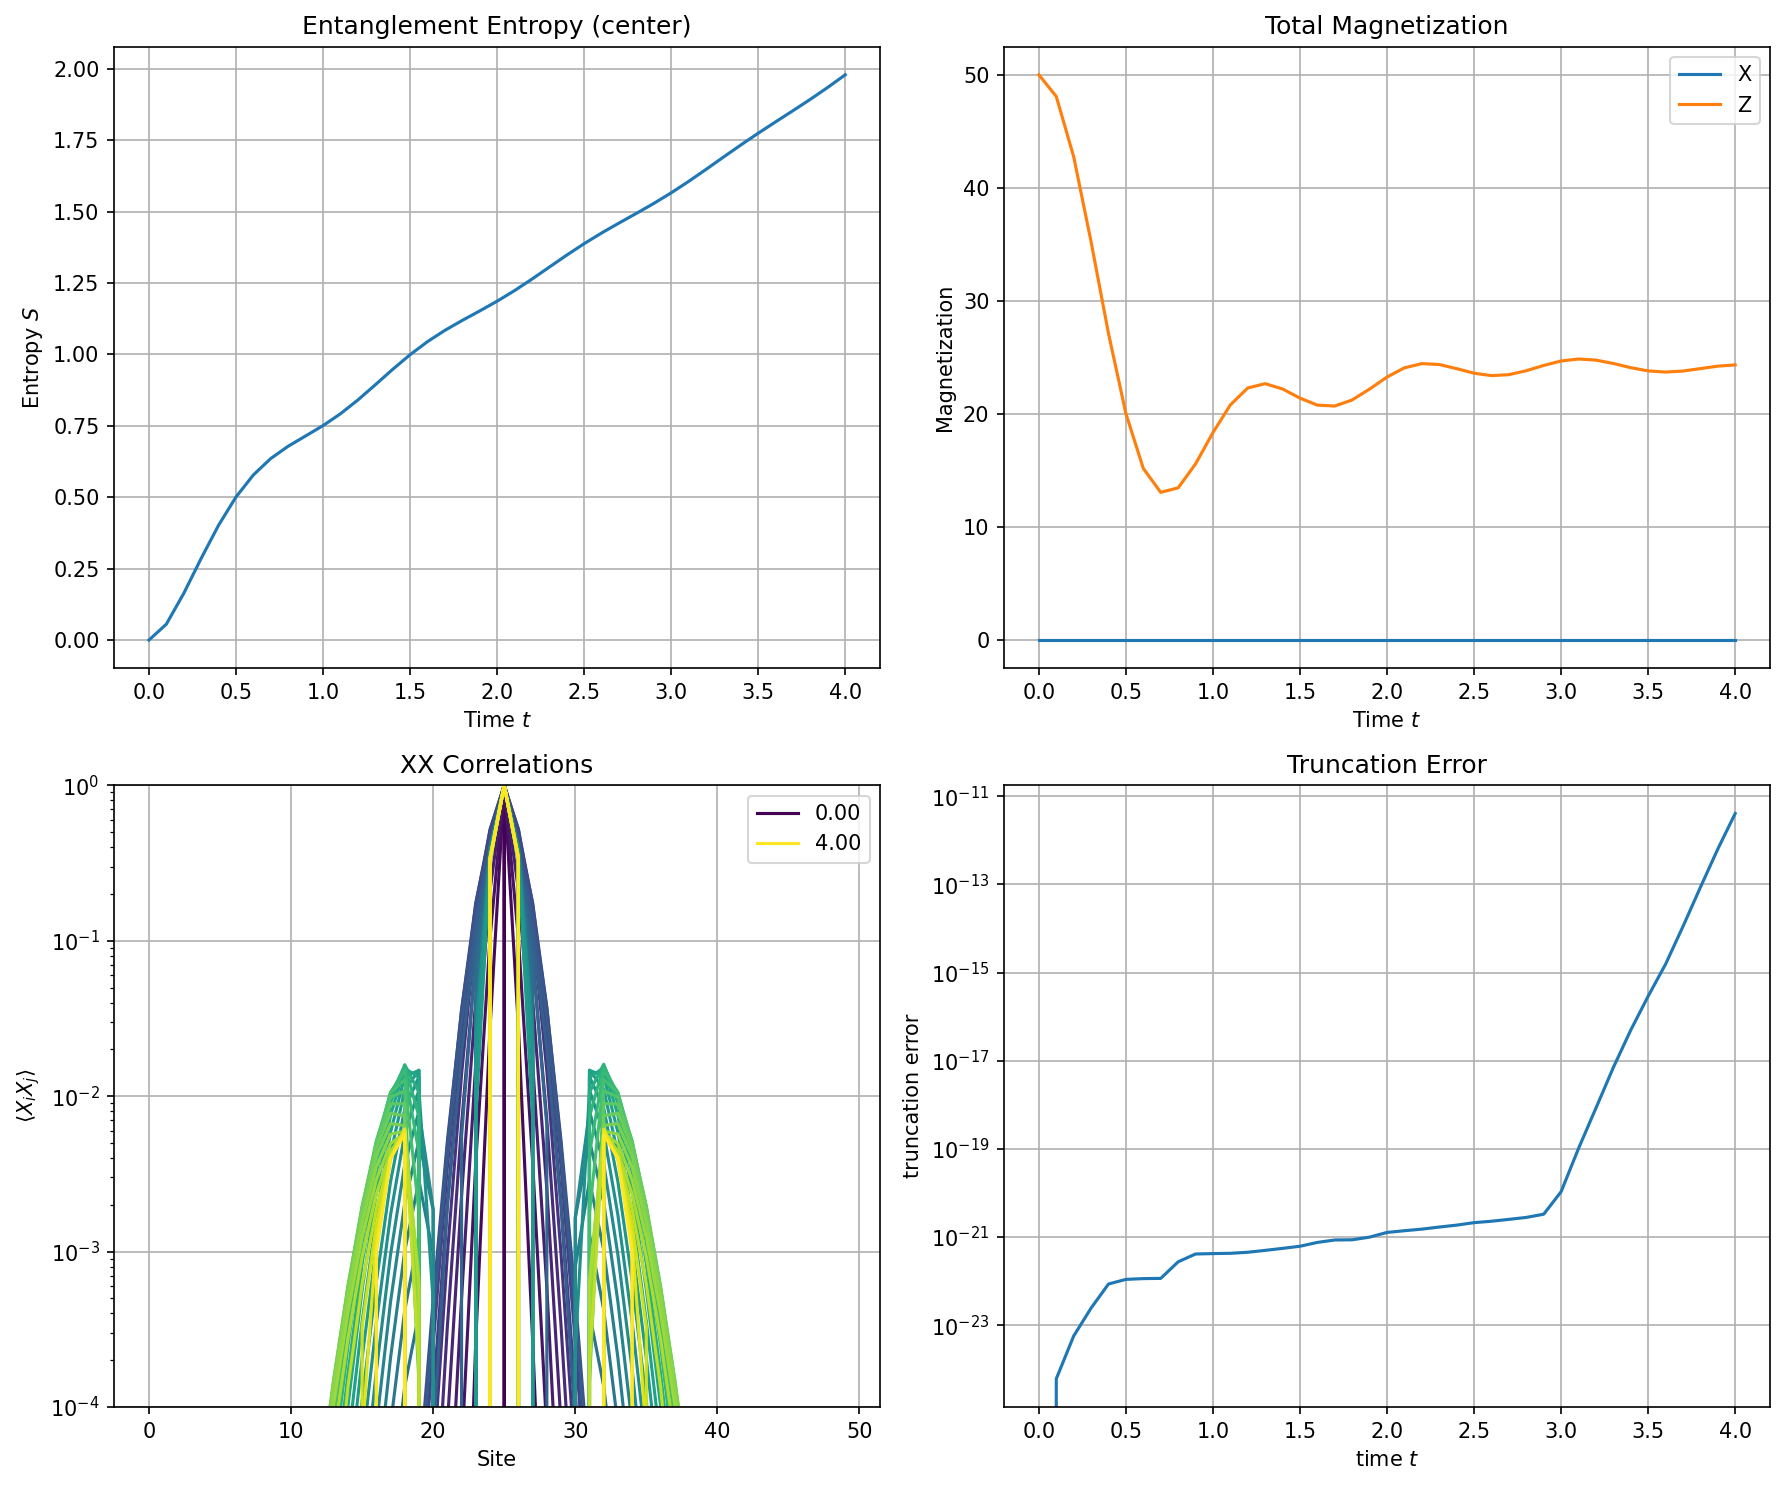

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Entanglement entropy at center
axes[0, 0].plot(data['t'], np.array(data['entropy'])[:, N//2])
axes[0, 0].set_xlabel('Time $t$')
axes[0, 0].set_ylabel('Entropy $S$')
axes[0, 0].set_title('Entanglement Entropy (center)')
axes[0, 0].grid(True)

# Plot 2: Magnetization
axes[0, 1].plot(data['t'], np.sum(data['Sx'], axis=1), label='X')
axes[0, 1].plot(data['t'], np.sum(data['Sz'], axis=1), label='Z')
axes[0, 1].set_xlabel('Time $t$')
axes[0, 1].set_ylabel('Magnetization')
axes[0, 1].set_title('Total Magnetization')
axes[0, 1].legend(loc='best')
axes[0, 1].grid(True)

# Plot 3: Correlations
corrs = np.array(data['corr_XX'])
tmax = data['t'][-1]
x = np.arange(N)
cmap = matplotlib.cm.viridis
for i, t in list(enumerate(data['t'])):
    if i == 0 or i == len(data['t']) - 1:
        label = '{t:.2f}'.format(t=t)
    else:
        label = None
    axes[1, 0].plot(x, corrs[i, N//2, :], color=cmap(t/tmax), label=label)
axes[1, 0].set_xlabel(r'Site')
axes[1, 0].set_ylabel(r'$\langle X_i X_j \rangle$')
axes[1, 0].set_title('XX Correlations')
axes[1, 0].set_yscale('log')
axes[1, 0].set_ylim(1.e-4, 1.)
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot 4: Truncation error
axes[1, 1].plot(data['t'], data['trunc_err'])
axes[1, 1].set_yscale('log')
#plt.ylim(1.e-15, 1.)
axes[1, 1].set_xlabel('time $t$')
axes[1, 1].set_ylabel('truncation error')
axes[1, 1].set_title('Truncation Error')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

Now, we focus on what we originally aimed to compute: the expectation value of the local operator $Z_{i=N/2}(t)$ evaluated at the center of the spin chain throughout the time evolution. 

We extract this value from our complete dataset by selecting only the Z-magnetization measurement at the center site (position $i = N/2$) and plot its evolution in time. This shows how the local operator's expectation value oscillates and evolves under the transverse-field Ising dynamics from $t=0$ to $t=T$.

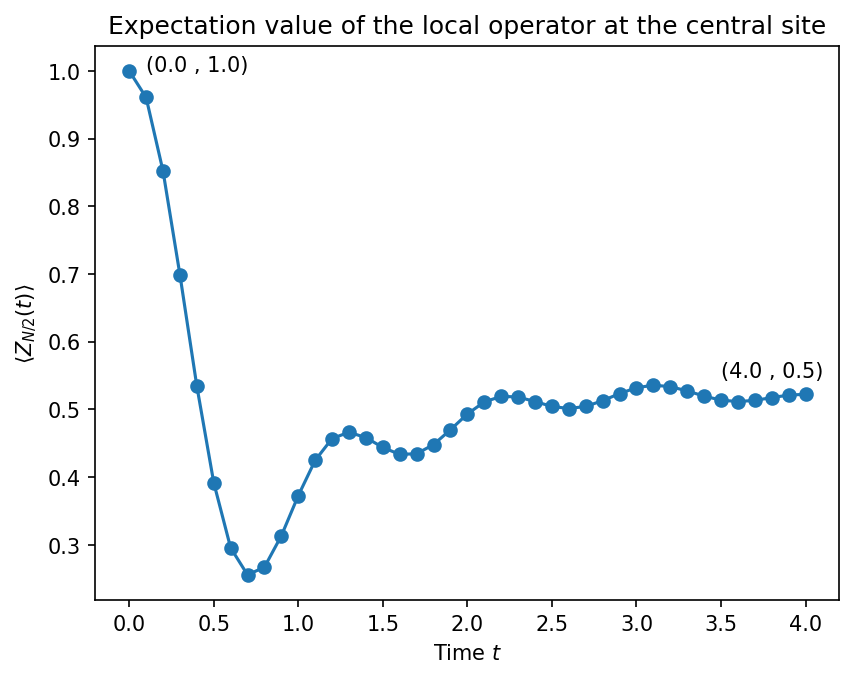

In [10]:
# Extract the expectation value of Z at the center site (i=N/2) at each time step
z_center = np.array([z[N//2] for z in data['Sz']])

# Plot 5: Magnetization at the central site
plt.plot(data['t'], z_center, 'o-')
plt.xlabel('Time $t$')
plt.ylabel('$\\langle Z_{N/2}(t) \\rangle$')
plt.title('Expectation value of the local operator at the central site')
# Add text annotations for initial and final values
plt.text(data['t'][0] + 0.1, z_center[0], f"({data['t'][0]:.1f} , {z_center[0]:.1f})", ha='left')
plt.text(data['t'][-1] -0.2, z_center[-1] + 0.02, f'({data["t"][-1]:.1f} , {z_center[-1]:.1f})', va='bottom', ha='center')
plt.show()

## Part II: Expectation value via transverse contraction

### Identify columns of the tensor network as transfer matrices E in MPO form

To perform the spatial contraction of the spacetime tensor network, we need to reorganize the TEBD evolution gates into transfer matrices that represent vertical columns of the network.

The key idea is to swap the role of physical and virtual indices:
- In standard TEBD/MPO: physical indices are spin states, virtual indices connect sites.
- In transfer matrices: virtual indices (temporal) are spin states, physical indices (spatial bonds) connect columns.

We implement this in two steps:

1. Gate Decomposition (`split_gate_to_mpo_tensors`):
Each 2-body TEBD gate $U_{i,i+1}$ acting on neighboring sites is decomposed via SVD into two 1-body MPO tensors $M_{\text{left}}$ and $M_{\text{right}}$.

2. Transfer Matrix Construction (`build_transfer_matrices`):
For each Trotter substep, we combine the spatial sites to form the complete transfer matrix $E$ for each site.


In [120]:
def split_gate_to_mpo_tensors(gate):
    """Split a 2-body TEBD gate into 1-body MPO tensors for spatial columns via SVD.
    
    The TEBD gate has shape (2, 2, 2, 2) with legs ordered as (s_i, s_j, s_i', s_j'):
    - s_i, s_j: input physical indices for sites bond_index and bond_index+1
    - s_i', s_j': output physical indices for sites bond_index and bond_index+1
    
    We transpose to group site pairs: (s_i, s_i', s_j, s_j'),
    then SVD factorizes the gate to split it between left and right spatial positions.
    
    Args:
        gate: (2,2,2,2) complex ndarray representing a 2-body TEBD gate
        bond_index: bond index (1 to N-1 in practice); gate acts between sites bond_index and bond_index+1
        N: total number of sites in the chain
    
    Returns:
        M_left: (2, 2, D) left MPO tensor for spatial site bond_index (format: s_i, s_i', D)
        M_right: (D, 2, 2) right MPO tensor for spatial site bond_index+1 (format: D, s_j, s_j')
        where D is the SVD bond dimension (rank of factorization)
    """

    # Convert gate from npc array to numpy array
    gate = gate.to_ndarray()
    
    # Transpose to group indices for each site.
    gate_reordered = np.transpose(gate, (0, 2, 1, 3))
    
    # Reshape into 2D matrix (4, 4) for SVD: rows for site i and columns for site j
    mat = gate_reordered.reshape(4, 4)
    U, S, Vh = LA.svd(mat, full_matrices=False)
    
    # Split singular values equally
    U_left = U @ np.diag(np.sqrt(S))
    V_right = np.diag(np.sqrt(S)) @ Vh
    
    # Reshape to MPO form: (phys, phys', virtual)
    M_left = U_left.reshape(2, 2, -1)   # (s_i, s_i', D)
    M_right = V_right.reshape(-1, 2, 2) # (D, s_j, s_j')
    
    return M_left, M_right

In [162]:
def build_transfer_matrices(U_layers, order=None, n_steps=None):
    """Build all transfer matrices E from TEBD gates (extended to full evolution time).
    
    Args:
        U_layers: list of Trotter sub-steps from eng._U (unique even/odd gates)
        order: Suzuki-Trotter order (defaults to tebd_params["order"])
        n_steps: Number of Trotter steps per dt (defaults to tebd_params["N_steps"])
    
    Returns:
        E: list of transfer matrix with shape (2, 2, D_left, D_right) where:
           - (2, 2) are spatial bonds
           - (D_left, D_right) are temporal bonds
    """
    if order is None:
        order = tebd_params["order"]
    if n_steps is None:
        n_steps = tebd_params["N_steps"]

    # Full Suzuki-Trotter schedule used by eng.evolve
    schedule = eng.suzuki_trotter_decomposition(order, n_steps)
    
    # First, build E for one time step (dt)
    E_one_step = []  # E_one_step[site][substep]
    
    # Loop over all spatial sites
    for site_index in range(N):
        E_site = []  # List of transfer matrices for this site at one time step
        
        # Loop over the full Suzuki-Trotter schedule
        for U_idx_dt, odd in schedule:
            substep = U_layers[U_idx_dt]
            
            # Contribution from LEFT bond (site_index-1, site_index)
            left_bond = site_index
            left_active = (left_bond % 2) == odd
            if site_index > 0 and left_active and substep[left_bond] is not None:
                gate_left = substep[left_bond]
                M_left, M_right = split_gate_to_mpo_tensors(gate_left)
                # This site gets M_right part: (D, 2, 2) -> transpose to (2, 2, D)
                E_from_left = np.transpose(M_right, (1, 2, 0))
            else:
                # Boundary or no gate: use identity
                E_from_left = np.eye(2, dtype=complex).reshape(2, 2, 1)

            # Contribution from RIGHT bond (site_index, site_index+1)
            right_bond = site_index + 1
            right_active = (right_bond % 2) == odd
            if site_index < N - 1 and right_active and substep[right_bond] is not None:
                gate_right = substep[right_bond]
                M_left, M_right = split_gate_to_mpo_tensors(gate_right)
                # This site gets M_left part: already (2, 2, D)
                E_from_right = M_left
            else:
                # Boundary or no gate: use identity
                E_from_right = np.eye(2, dtype=complex).reshape(2, 2, 1)
            
            # Combine contributions: (2, 2, D_left) x (2, 2, D_right) -> (2, 2, D_left, D_right)
            E_substep = np.einsum('ijk,ijl->ijkl', E_from_left, E_from_right)
            E_site.append(E_substep)
        
        E_one_step.append(E_site)
    
    return E_one_step

In [163]:
# Build transfer matrices for one time step (single Trotter layer)
E_one_step = build_transfer_matrices(eng._U)

print("Structure of the transfer matrices\n")
print(f"Structure: E[site][substep]")
print(f"Number of sites: {len(E_one_step)}")
print(f"Number of substeps per time step: {len(E_one_step[0])}\n")

print(f"Shape of E[{N//2}][0] (center site, first substep):")
print(f"  {E_one_step[N//2][0].shape} = (2, 2, D_left, D_right)")


Structure of the transfer matrices

Structure: E[site][substep]
Number of sites: 50
Number of substeps per time step: 3

Shape of E[25][0] (center site, first substep):
  (2, 2, 4, 1) = (2, 2, D_left, D_right)


In [164]:
def build_full_columns(E_one_step, T=T):
    """Build complete spacetime columns for all sites, combining ket and bra in a sandwich structure.
    
    For each spatial site, this function builds a vertical column that represents the full
    spacetime tensor network slice at that position. Each column contains (from bottom to top):
    
    1. Initial MPS tensor (ket side): psi[site] with shape (D_left, d_phys, D_right)
    2. Time evolution gates (ket side): Transfer matrices E for each time step
    3. Time evolution gates (bra side): Transfer matrices E† in reverse order
    4. Initial MPS tensor (bra side): psi[site]† with shape (D_right, d_phys, D_left)
    
    This creates the full bra-ket sandwich: ⟨ψ(T)| ... |ψ(0)⟩ for spatial contraction.
    
    Args:
        E_one_step: Transfer matrices for one time step, structure E_one_step[site][substep]
                    Each E has shape (d_in, d_out, D_left, D_right)
        T: Final time to evolve to (default: global T)
        
    Returns:
        E: Structure E[site][layer_idx] where each site contains the full vertical column:
           - First layers: initial MPS + forward time evolution (ket |ψ⟩)
           - Last layers: backward time evolution + initial MPS adjoint (bra ⟨ψ|)
           Total layers per site = 2 * (1 + num_time_steps * num_substeps)
    """

    psi_initial = MPS.from_lat_product_state(M.lat, [['up']])
    
    # Calculate number of time steps needed to reach T
    num_time_steps = int(np.round(T / dt))
    num_substeps = len(E_one_step[0])
    
    E_full = []
    E_full_adj = []
    
    # Build column for each spatial site
    for site in range(N):

        column = []
        column_adj = []
        
        # First layer: initial MPS tensor at this site
        initial_tensor = psi_initial.get_B(site).to_ndarray()  # (D_left, d_phys, D_right)
        column.append(initial_tensor)
        column_adj.append(np.conj(initial_tensor))
        
        # Subsequent layers: apply E_one_step for each time step
        for time_step in range(num_time_steps):
            for substep in range(num_substeps):
                E_tensor = E_one_step[site][substep]  # (d_in, d_out, D_left, D_right)
                column.append(E_tensor)
                column_adj.append(np.conj(E_tensor).transpose(1, 0, 2, 3))
        
        E_full.append(column)
        E_full_adj.append(column_adj)
    
    E = []
    for site in range(N):
        E_site = []
        for i in E_full[site]: E_site.append(i)
        for j in range(len(E_full_adj[site])):
            E_site.append(E_full_adj[site][len(E_full_adj[site]) - 1 - j])
        E.append(E_site)
    
    return E

In [165]:
# Build the full spacetime columns (ket-bra sandwich structure)
E = build_full_columns(E_one_step, T=0.1)

num_time_steps = int(np.round(T / dt))
num_substeps = len(E_one_step[0])
layers_per_side = 1 + num_time_steps * num_substeps

print(f"\nStructure of E (complete bra-ket sandwich):")
print(f"  E[site][layer_idx]")
print(f"  Number of sites: {len(E)}")
print(f"  Total layers per site: {len(E[0])}")
print(f"    - Ket side (bottom): {layers_per_side} layers")
print(f"    - Bra side (top): {layers_per_side} layers")

print(f"\nExample shapes:")
print(f"  E[0][0] (site 0, initial MPS ket): {E[0][0].shape}")
print(f"  E[0][1] (site 0, first transfer matrix ket): {E[0][1].shape}")
print(f"  E[0][-2] (site 0, first transfer matrix bra): {E[0][-2].shape}")
print(f"  E[0][-1] (site 0, initial MPS bra): {E[0][-1].shape}")
print(f"\n  E[{N//2}][0] (center site, initial MPS ket): {E[N//2][0].shape}")
print(f"  E[{N//2}][-1] (center site, initial MPS bra): {E[N//2][-1].shape}")



Structure of E (complete bra-ket sandwich):
  E[site][layer_idx]
  Number of sites: 50
  Total layers per site: 8
    - Ket side (bottom): 121 layers
    - Bra side (top): 121 layers

Example shapes:
  E[0][0] (site 0, initial MPS ket): (1, 2, 1)
  E[0][1] (site 0, first transfer matrix ket): (2, 2, 1, 4)
  E[0][-2] (site 0, first transfer matrix bra): (2, 2, 1, 4)
  E[0][-1] (site 0, initial MPS bra): (1, 2, 1)

  E[25][0] (center site, initial MPS ket): (1, 2, 1)
  E[25][-1] (center site, initial MPS bra): (1, 2, 1)


### Define the effective states $\bra{L}$ and $\ket{R}$

In [167]:
def left_effective_state(E):
    """Compute the left effective boundary state ⟨L| by HORIZONTAL spatial contraction.
    
    Starting from site 0, we sequentially contract left spatially through sites (0→1→2→...→N//2).
    For each site, we contract the accumulated left state with the new column E[site]
    along the spatial bond (D_right of state_L connects to D_left of E[site]).
    
    Each layer evolves independently:
    - state_L[layer_idx] = accumulated contraction at layer layer_idx
    - After each site contraction, apply SVD truncation
    
    This builds the effective left boundary state ⟨L| representing all contracted information to the left of the center site.
    
    Args:
        E: Complete spacetime columns, structure E[site][layer_idx]
           Each column contains: ket MPS, ket gates, bra gates, bra MPS (bottom to top)
        
    Returns:
        state_L: Left effective boundary state as a temporal MPS (list of tensors, one per layer)
        trunc_errors: List of truncation errors from SVD at each step
        bond_dims: List of bond dimensions at each step
    """
    
    num_layers = len(E[0])
    trunc_errors = []
    bond_dims = []
    
    # Initialize: state_L is a list of tensors, one for each layer
    state_L = [E[0][layer_idx] for layer_idx in range(num_layers)]

    for site in range(1, N//2):
        print(f"Contracting site {site}:")
        
        new_state_L = []
        
        for layer_idx in range(num_layers):
            print(f"  Layer {layer_idx}:")
            
            state_tensor = state_L[layer_idx]          # Accumulated state at this layer
            column_tensor = E[site][layer_idx]         # Column to contract with
                        
            # MPS tensors: (D_left, d_phys, D_right)
            if layer_idx == 0 or layer_idx == num_layers - 1:
                print(f"  Layer {layer_idx}: MPS contraction")
                print(f"    state_tensor.shape = {state_tensor.shape}")
                print(f"    column_tensor.shape = {column_tensor.shape}")
                if state_tensor.shape[2] != column_tensor.shape[0]:
                    print(f"    ERROR: D_right={state_tensor.shape[2]} != D_left={column_tensor.shape[0]}")
                contracted = ncon([state_tensor, column_tensor], [[-1, -2, 1], [1, -3, -4]]) # Result: (D_left_L, d_L, d_R, D_right_R)
                D_l, d_l, d_r, D_r = contracted.shape
                contracted = contracted.reshape(D_l, d_l * d_r, D_r)
                
                # SVD on the right bond
                mat = contracted.reshape(D_l * (d_l * d_r), D_r)
                U, S, Vh = LA.svd(mat, full_matrices=False, lapack_driver='gesvd')
                chi = min(len(S), chi_max)
                trunc_error = np.sqrt(np.sum(S[chi:] ** 2)) if len(S) > chi else 0.0
                U_trunc = U[:, :chi]
                S_trunc = S[:chi]
                mat_trunc = U_trunc @ np.diag(S_trunc)
                # Reshape back to 3D MPS form: (D_left, d_phys_fused, D_right)
                tensor_trunc = mat_trunc.reshape(D_l, d_l * d_r, chi)
                
                # Temporal truncation on physical index (d_phys_fused)
                d_phys = tensor_trunc.shape[1]
                mat_t = tensor_trunc.reshape(d_phys, D_l * chi)
                U_t, S_t, Vh_t = LA.svd(mat_t, full_matrices=False, lapack_driver='gesvd')
                chi_t = min(len(S_t), chi_max)
                trunc_error_t = np.sqrt(np.sum(S_t[chi_t:] ** 2)) if len(S_t) > chi_t else 0.0
                mat_t_trunc = np.diag(S_t[:chi_t]) @ Vh_t[:chi_t, :]
                tensor_trunc = mat_t_trunc.reshape(chi_t, D_l, chi).transpose(1, 0, 2)

                print(f"   Final truncated shape: {tensor_trunc.shape})")
            
            # Transfer matrices: (d_in, d_out, D_left, D_right)
            else:
                print(f"    Contracting transfer matrix: state {state_tensor.shape} x column {column_tensor.shape}")
                contracted = ncon([state_tensor, column_tensor], [[-1, -3, -5, 1],[-2, -4, 1, -6]]) # Result: (d_in_1, d_in_2, d_out_1, d_out_2, D_left, D_right)
                d_in_1, d_in_2, d_out_1, d_out_2, D_left, D_right = contracted.shape
                contracted = contracted.reshape(d_in_1 * d_in_2, d_out_1 * d_out_2, D_left, D_right)
                
                # SVD on the right bond
                d_in, d_out, D_l, D_r = contracted.shape
                mat = contracted.reshape(d_in * d_out * D_l, D_r)
                U, S, Vh = LA.svd(mat, full_matrices=False, lapack_driver='gesvd')

                chi = min(len(S), chi_max)
                trunc_error = np.sqrt(np.sum(S[chi:] ** 2)) if len(S) > chi else 0.0
                
                U_trunc = U[:, :chi]
                S_trunc = S[:chi]
                mat_trunc = U_trunc @ np.diag(S_trunc)
                
                # Reshape back to 4D transfer matrix form: (d_in, d_out, D_left, D_right)
                tensor_trunc = mat_trunc.reshape(d_in, d_out, D_l, chi)
                
                # Temporal truncation on d_in
                d_in = tensor_trunc.shape[0]
                d_out = tensor_trunc.shape[1]
                mat_in = tensor_trunc.reshape(d_in, d_out * D_l * chi)
                U_in, S_in, Vh_in = LA.svd(mat_in, full_matrices=False, lapack_driver='gesvd')
                chi_in = min(len(S_in), chi_max)
                trunc_error_in = np.sqrt(np.sum(S_in[chi_in:] ** 2)) if len(S_in) > chi_in else 0.0
                mat_in_trunc = np.diag(S_in[:chi_in]) @ Vh_in[:chi_in, :]
                tensor_trunc = mat_in_trunc.reshape(chi_in, d_out, D_l, chi)
                
                # Temporal truncation on d_out
                tensor_trunc = tensor_trunc.transpose(1, 0, 2, 3)
                mat_out = tensor_trunc.reshape(d_out, chi_in * D_l * chi)
                U_out, S_out, Vh_out = LA.svd(mat_out, full_matrices=False, lapack_driver='gesvd')
                chi_out = min(len(S_out), chi_max)
                trunc_error_out = np.sqrt(np.sum(S_out[chi_out:] ** 2)) if len(S_out) > chi_out else 0.0
                mat_out_trunc = np.diag(S_out[:chi_out]) @ Vh_out[:chi_out, :]
                tensor_trunc = mat_out_trunc.reshape(chi_out, chi_in, D_l, chi).transpose(1, 0, 2, 3)
                trunc_error = np.sqrt(trunc_error ** 2 + trunc_error_in ** 2 + trunc_error_out ** 2)

                print(f"   Final truncated shape: {tensor_trunc.shape})")
            
            # Normalize to prevent exponential growth/decay
            norm = np.linalg.norm(tensor_trunc)
            if norm > 1e-14:
                tensor_trunc = tensor_trunc / norm
            
            new_state_L.append(tensor_trunc)
            trunc_errors.append(trunc_error)
            bond_dims.append(chi)
        
        state_L = new_state_L
        print(f"  Site {site} complete\n")
    
    return state_L, trunc_errors, bond_dims

In [168]:
left_state, left_trunc_errs, left_bond_dims = left_effective_state(E)

Contracting site 1:
  Layer 0:
  Layer 0: MPS contraction
    state_tensor.shape = (1, 2, 1)
    column_tensor.shape = (1, 2, 1)
   Final truncated shape: (1, 1, 1))
  Layer 1:
    Contracting transfer matrix: state (2, 2, 1, 4) x column (2, 2, 4, 1)
   Final truncated shape: (4, 4, 1, 1))
  Layer 2:
    Contracting transfer matrix: state (2, 2, 1, 1) x column (2, 2, 1, 4)
   Final truncated shape: (4, 4, 1, 4))
  Layer 3:
    Contracting transfer matrix: state (2, 2, 1, 4) x column (2, 2, 4, 1)
   Final truncated shape: (4, 4, 1, 1))
  Layer 4:
    Contracting transfer matrix: state (2, 2, 1, 4) x column (2, 2, 4, 1)
   Final truncated shape: (4, 4, 1, 1))
  Layer 5:
    Contracting transfer matrix: state (2, 2, 1, 1) x column (2, 2, 1, 4)
   Final truncated shape: (4, 4, 1, 4))
  Layer 6:
    Contracting transfer matrix: state (2, 2, 1, 4) x column (2, 2, 4, 1)
   Final truncated shape: (4, 4, 1, 1))
  Layer 7:
  Layer 7: MPS contraction
    state_tensor.shape = (1, 2, 1)
    column_

Contracting site 1:
  Layer 0:
  Layer 0: MPS contraction
    state_tensor.shape = (1, 2, 1)
    column_tensor.shape = (1, 2, 1)
   Final truncated shape: (1, 1, 1))
  Layer 1:
    Contracting transfer matrix: state (2, 2, 1, 4) x column (2, 2, 4, 1)
   Final truncated shape: (4, 4, 1, 1))
  Layer 2:
    Contracting transfer matrix: state (2, 2, 1, 1) x column (2, 2, 1, 4)
   Final truncated shape: (4, 4, 1, 4))
  Layer 3:
    Contracting transfer matrix: state (2, 2, 1, 4) x column (2, 2, 4, 1)
   Final truncated shape: (4, 4, 1, 1))
  Layer 4:
    Contracting transfer matrix: state (2, 2, 1, 4) x column (2, 2, 4, 1)
   Final truncated shape: (4, 4, 1, 1))
  Layer 5:
    Contracting transfer matrix: state (2, 2, 1, 1) x column (2, 2, 1, 4)
   Final truncated shape: (4, 4, 1, 4))
  Layer 6:
    Contracting transfer matrix: state (2, 2, 1, 4) x column (2, 2, 4, 1)
   Final truncated shape: (4, 4, 1, 1))
  Layer 7:
  Layer 7: MPS contraction
    state_tensor.shape = (1, 2, 1)
    column_

   Final truncated shape: (64, 64, 1, 4))
  Layer 3:
    Contracting transfer matrix: state (32, 32, 1, 4) x column (2, 2, 4, 1)
   Final truncated shape: (64, 64, 1, 1))
  Layer 4:
    Contracting transfer matrix: state (32, 32, 1, 4) x column (2, 2, 4, 1)
   Final truncated shape: (64, 64, 1, 1))
  Layer 5:
    Contracting transfer matrix: state (32, 32, 1, 1) x column (2, 2, 1, 4)
   Final truncated shape: (64, 64, 1, 4))
  Layer 6:
    Contracting transfer matrix: state (32, 32, 1, 4) x column (2, 2, 4, 1)
   Final truncated shape: (64, 64, 1, 1))
  Layer 7:
  Layer 7: MPS contraction
    state_tensor.shape = (1, 1, 1)
    column_tensor.shape = (1, 2, 1)
   Final truncated shape: (1, 1, 1))
  Site 5 complete

Contracting site 6:
  Layer 0:
  Layer 0: MPS contraction
    state_tensor.shape = (1, 1, 1)
    column_tensor.shape = (1, 2, 1)
   Final truncated shape: (1, 1, 1))
  Layer 1:
    Contracting transfer matrix: state (64, 64, 1, 1) x column (2, 2, 1, 4)
   Final truncated shape

In [170]:
def right_effective_state(E):
    """Compute the right effective boundary state |R> by HORIZONTAL spatial contraction.

    Starting from site N-1, we sequentially contract right spatially through sites
    (N-1→N-2→...→N//2+1). For each site, we contract the accumulated right state with
    the new column E[site] along the spatial bond (D_left of state_R connects to
    D_right of E[site]).

    Each layer evolves independently:
    - state_R[layer_idx] = accumulated contraction at layer layer_idx
    - After each site contraction, apply SVD truncation

    Args:
        E: Complete spacetime columns, structure E[site][layer_idx]
           Each column contains: ket MPS, ket gates, bra gates, bra MPS (bottom to top)

    Returns:
        state_R: Right effective boundary state as a temporal MPS (list of tensors, one per layer)
        trunc_errors: List of truncation errors from SVD at each step
        bond_dims: List of bond dimensions at each step
    """

    num_layers = len(E[0])
    trunc_errors = []
    bond_dims = []

    # Initialize: state_R is a list of tensors, one for each layer
    state_R = [E[N - 1][layer_idx] for layer_idx in range(num_layers)]

    for site in range(N - 2, N // 2, -1):
        print(f"Contracting site {site}:")

        new_state_R = []

        for layer_idx in range(num_layers):
            state_tensor = state_R[layer_idx]          # Accumulated state at this layer
            column_tensor = E[site][layer_idx]         # Column to contract with

            # MPS tensors: (D_left, d_phys, D_right)
            if layer_idx == 0 or layer_idx == num_layers - 1:
                contracted = ncon([column_tensor, state_tensor], [[-1, -2, 1], [1, -3, -4]])
                D_l, d_l, d_r, D_r = contracted.shape
                contracted = contracted.reshape(D_l, d_l * d_r, D_r)

                # SVD on the right bond
                mat = contracted.reshape(D_l * (d_l * d_r), D_r)
                U, S, Vh = LA.svd(mat, full_matrices=False, lapack_driver='gesvd')

                chi = min(len(S), chi_max)
                trunc_error = np.sqrt(np.sum(S[chi:] ** 2)) if len(S) > chi else 0.0

                U_trunc = U[:, :chi]
                S_trunc = S[:chi]
                mat_trunc = U_trunc @ np.diag(S_trunc)

                # Reshape back to 3D MPS form: (D_left, d_phys_fused, D_right)
                tensor_trunc = mat_trunc.reshape(D_l, d_l * d_r, chi)

                # Temporal truncation on physical index (d_phys_fused)
                d_phys = tensor_trunc.shape[1]
                mat_t = tensor_trunc.reshape(d_phys, D_l * chi)
                U_t, S_t, Vh_t = LA.svd(mat_t, full_matrices=False, lapack_driver='gesvd')
                chi_t = min(len(S_t), chi_max)
                trunc_error_t = np.sqrt(np.sum(S_t[chi_t:] ** 2)) if len(S_t) > chi_t else 0.0
                mat_t_trunc = np.diag(S_t[:chi_t]) @ Vh_t[:chi_t, :]
                tensor_trunc = mat_t_trunc.reshape(chi_t, D_l, chi).transpose(1, 0, 2)

            # Transfer matrices: (d_in, d_out, D_left, D_right)
            else:
                contracted = ncon([column_tensor, state_tensor], [[-1, -3, -5, 1], [-2, -4, 1, -6]])
                d_in_1, d_in_2, d_out_1, d_out_2, D_left, D_right = contracted.shape
                contracted = contracted.reshape(d_in_1 * d_in_2, d_out_1 * d_out_2, D_left, D_right)

                # SVD on the right bond
                d_in, d_out, D_l, D_r = contracted.shape
                mat = contracted.reshape(d_in * d_out * D_l, D_r)
                U, S, Vh = LA.svd(mat, full_matrices=False, lapack_driver='gesvd')

                chi = min(len(S), chi_max)
                trunc_error = np.sqrt(np.sum(S[chi:] ** 2)) if len(S) > chi else 0.0

                U_trunc = U[:, :chi]
                S_trunc = S[:chi]
                mat_trunc = U_trunc @ np.diag(S_trunc)

                # Reshape back to 4D transfer matrix form: (d_in, d_out, D_left, D_right)
                tensor_trunc = mat_trunc.reshape(d_in, d_out, D_l, chi)

                # Temporal truncation on d_in
                d_in = tensor_trunc.shape[0]
                d_out = tensor_trunc.shape[1]
                mat_in = tensor_trunc.reshape(d_in, d_out * D_l * chi)
                U_in, S_in, Vh_in = LA.svd(mat_in, full_matrices=False, lapack_driver='gesvd')
                chi_in = min(len(S_in), chi_max)
                trunc_error_in = np.sqrt(np.sum(S_in[chi_in:] ** 2)) if len(S_in) > chi_in else 0.0
                mat_in_trunc = np.diag(S_in[:chi_in]) @ Vh_in[:chi_in, :]
                tensor_trunc = mat_in_trunc.reshape(chi_in, d_out, D_l, chi)

                # Temporal truncation on d_out
                tensor_trunc = tensor_trunc.transpose(1, 0, 2, 3)
                mat_out = tensor_trunc.reshape(d_out, chi_in * D_l * chi)
                U_out, S_out, Vh_out = LA.svd(mat_out, full_matrices=False, lapack_driver='gesvd')
                chi_out = min(len(S_out), chi_max)
                trunc_error_out = np.sqrt(np.sum(S_out[chi_out:] ** 2)) if len(S_out) > chi_out else 0.0
                mat_out_trunc = np.diag(S_out[:chi_out]) @ Vh_out[:chi_out, :]
                tensor_trunc = mat_out_trunc.reshape(chi_out, chi_in, D_l, chi).transpose(1, 0, 2, 3)
                trunc_error = np.sqrt(trunc_error ** 2 + trunc_error_in ** 2 + trunc_error_out ** 2)

            # Normalize to prevent exponential growth/decay
            norm = np.linalg.norm(tensor_trunc)
            if norm > 1e-14:
                tensor_trunc = tensor_trunc / norm

            new_state_R.append(tensor_trunc)
            trunc_errors.append(trunc_error)
            bond_dims.append(chi)

        state_R = new_state_R
        print(f"  Site {site} complete\n")
        clear_output(wait=True)

    return state_R, trunc_errors, bond_dims

In [171]:
right_state, right_trunc_errs, right_bond_dims = right_effective_state(E)

Contracting site 26:
  Site 26 complete



### Computation of the expectation value $\langle Z_{i=N/2} (t)\rangle$

In [48]:
def contract_LER(left_state, E_col, right_state):
    """Contract L with the center column E, then with R, and finally contract vertically.
    
    This function performs the complete contraction to compute <L|E|R>:
    1. Horizontal contraction: L + E -> LE
    2. Horizontal contraction: LE + R -> LER
    3. Vertical contraction: Contract all temporal layers to obtain final scalar
    
    Args:
        left_state: Left effective boundary state (list of tensors, one per layer)
        E_col: Center column E[N//2] (list of tensors, one per layer)
        right_state: Right effective boundary state (list of tensors, one per layer)
    
    Returns:
        scalar: Complex number representing <Z_{N/2}(t)>
    """
    num_layers = len(left_state)
    if len(right_state) != num_layers:
        raise ValueError("left_state and right_state must have the same number of layers")
    
    new_state_L = []
    
    for layer_idx in range(num_layers):
        state_tensor = left_state[layer_idx]
        column_tensor = E_col[layer_idx]
        print(f"Layer {layer_idx}: column {column_tensor.shape} x state {state_tensor.shape}")
        
        # MPS tensors: (D_left, d_phys, D_right)
        if layer_idx == 0 or layer_idx == num_layers - 1:
            contracted = ncon([state_tensor, column_tensor], [[-1, -2, 1], [1, -3, -4]])
            D_l, d_l, d_r, D_r = contracted.shape
            contracted = contracted.reshape(D_l, d_l * d_r, D_r)
            # Keep the physical dimension at boundaries (D_r is 1 here).
            tensor_trunc = contracted
        
        # Transfer matrices: (d_in, d_out, D_left, D_right)
        else:
            contracted = ncon([state_tensor, column_tensor], [[-1, -3, -5, 1], [-2, -4, 1, -6]])
            d_in_1, d_in_2, d_out_1, d_out_2, D_left, D_right = contracted.shape
            contracted = contracted.reshape(d_in_1 * d_in_2, d_out_1 * d_out_2, D_left, D_right)
            
            # SVD on the right bond
            d_in, d_out, D_l, D_r = contracted.shape
            mat = contracted.reshape(d_in * d_out * D_l, D_r)
            U, S, Vh = LA.svd(mat, full_matrices=False, lapack_driver='gesvd')
            chi = min(len(S), chi_max)
            U_trunc = U[:, :chi]
            S_trunc = S[:chi]
            mat_trunc = U_trunc @ np.diag(S_trunc)
            tensor_trunc = mat_trunc.reshape(d_in, d_out, D_l, chi)
            
            # Temporal truncation on d_in
            d_in = tensor_trunc.shape[0]
            d_out = tensor_trunc.shape[1]
            mat_in = tensor_trunc.reshape(d_in, d_out * D_l * chi)
            U_in, S_in, Vh_in = LA.svd(mat_in, full_matrices=False, lapack_driver='gesvd')
            chi_in = min(len(S_in), int(np.sqrt(chi_max)))
            mat_in_trunc = np.diag(S_in[:chi_in]) @ Vh_in[:chi_in, :]
            tensor_trunc = mat_in_trunc.reshape(chi_in, d_out, D_l, chi)
            
            # Temporal truncation on d_out
            tensor_trunc = tensor_trunc.transpose(1, 0, 2, 3)
            mat_out = tensor_trunc.reshape(d_out, chi_in * D_l * chi)
            U_out, S_out, Vh_out = LA.svd(mat_out, full_matrices=False, lapack_driver='gesvd')
            chi_out = min(len(S_out), int(np.sqrt(chi_max)))
            mat_out_trunc = np.diag(S_out[:chi_out]) @ Vh_out[:chi_out, :]
            tensor_trunc = mat_out_trunc.reshape(chi_out, chi_in, D_l, chi).transpose(1, 0, 2, 3)
        
        norm = np.linalg.norm(tensor_trunc)
        if norm > 1e-14:
            tensor_trunc = tensor_trunc / norm
        
        new_state_L.append(tensor_trunc)
    
    new_state_LR = []
    
    for layer_idx in range(num_layers):
        state_tensor = right_state[layer_idx]
        column_tensor = new_state_L[layer_idx]
        print(f"Layer {layer_idx}: column {column_tensor.shape} x state {state_tensor.shape}")
        
        # MPS tensors: (D_left, d_phys, D_right)
        if layer_idx == 0 or layer_idx == num_layers - 1:
            contracted = ncon([column_tensor, state_tensor], [[-1, -2, 1], [1, -3, -4]])
            D_l, d_l, d_r, D_r = contracted.shape
            contracted = contracted.reshape(D_l, d_l * d_r, D_r)
            # Keep the physical dimension at boundaries (D_r is 1 here).
            tensor_trunc = contracted
        
        # Transfer matrices: (d_in, d_out, D_left, D_right)
        else:
            contracted = ncon([column_tensor, state_tensor], [[-1, -3, -5, 1], [-2, -4, 1, -6]])
            d_in_1, d_in_2, d_out_1, d_out_2, D_left, D_right = contracted.shape
            contracted = contracted.reshape(d_in_1 * d_in_2, d_out_1 * d_out_2, D_left, D_right)
            
            # SVD on the right bond
            d_in, d_out, D_l, D_r = contracted.shape
            mat = contracted.reshape(d_in * d_out * D_l, D_r)
            U, S, Vh = LA.svd(mat, full_matrices=False, lapack_driver='gesvd')
            chi = min(len(S), chi_max)
            U_trunc = U[:, :chi]
            S_trunc = S[:chi]
            mat_trunc = U_trunc @ np.diag(S_trunc)
            tensor_trunc = mat_trunc.reshape(d_in, d_out, D_l, chi)
            
            # Temporal truncation on d_in
            d_in = tensor_trunc.shape[0]
            d_out = tensor_trunc.shape[1]
            mat_in = tensor_trunc.reshape(d_in, d_out * D_l * chi)
            U_in, S_in, Vh_in = LA.svd(mat_in, full_matrices=False, lapack_driver='gesvd')
            chi_in = min(len(S_in), int(np.sqrt(chi_max)))
            mat_in_trunc = np.diag(S_in[:chi_in]) @ Vh_in[:chi_in, :]
            tensor_trunc = mat_in_trunc.reshape(chi_in, d_out, D_l, chi)
            
            # Temporal truncation on d_out
            tensor_trunc = tensor_trunc.transpose(1, 0, 2, 3)
            mat_out = tensor_trunc.reshape(d_out, chi_in * D_l * chi)
            U_out, S_out, Vh_out = LA.svd(mat_out, full_matrices=False, lapack_driver='gesvd')
            chi_out = min(len(S_out), int(np.sqrt(chi_max)))
            mat_out_trunc = np.diag(S_out[:chi_out]) @ Vh_out[:chi_out, :]
            tensor_trunc = mat_out_trunc.reshape(chi_out, chi_in, D_l, chi).transpose(1, 0, 2, 3)
        
        norm = np.linalg.norm(tensor_trunc)
        if norm > 1e-14:
            tensor_trunc = tensor_trunc / norm
        
        new_state_LR.append(tensor_trunc)
    
    return new_state_LR

In [49]:
L_E_R = contract_LER(left_state, E[N//2], right_state)

Layer 0: column (1, 2, 1) x state (1, 1, 1)
Layer 1: column (2, 2, 4, 4) x state (100, 100, 1, 4)
Layer 2: column (2, 2, 4, 4) x state (100, 100, 1, 4)
Layer 3: column (2, 2, 4, 4) x state (100, 100, 1, 4)
Layer 4: column (2, 2, 4, 4) x state (100, 100, 1, 4)
Layer 5: column (1, 2, 1) x state (1, 1, 1)
Layer 0: column (1, 2, 1) x state (1, 1, 1)
Layer 1: column (10, 10, 1, 4) x state (100, 100, 4, 1)
Layer 2: column (10, 10, 1, 4) x state (100, 100, 4, 1)
Layer 3: column (10, 10, 1, 4) x state (100, 100, 4, 1)
Layer 4: column (10, 10, 1, 4) x state (100, 100, 4, 1)
Layer 5: column (1, 2, 1) x state (1, 1, 1)


In [51]:
print(L_E_R[0].shape)
print(L_E_R[1].shape)

(1, 2, 1)
(10, 10, 1, 1)


In [ ]:
def contract_mps_to_scalar(L_E_R):
    """Contract temporal MPS L_E_R down to a scalar.

    Contraction is done along the vertical physical indices (d_in/d_out), while
    horizontal bonds (D_left/D_right) are expected to be 1 after L-E-R contraction.
    """
    if len(L_E_R) == 0:
        raise ValueError("L_E_R must be a non-empty list of tensors")

    current = None
    closed = False

    for layer_idx, tensor in enumerate(L_E_R):
        if tensor.ndim == 3:
            if tensor.shape[0] != 1 or tensor.shape[2] != 1:
                raise ValueError(
                    "Expected D_left=D_right=1 for MPS layers, got "
                    f"{tensor.shape} at layer {layer_idx}"
                )
            vec = tensor.squeeze()
            if vec.ndim == 0:
                vec = np.array([vec])
            if current is None:
                current = vec
            else:
                if current.shape[0] != vec.shape[0]:
                    raise ValueError(
                        "Physical mismatch at layer "
                        f"{layer_idx}: {current.shape[0]} vs {vec.shape[0]}"
                    )
                current = current @ vec
                closed = True
        elif tensor.ndim == 4:
            if current is None:
                raise ValueError("Transfer layer before boundary vector")
            if tensor.shape[2] != 1 or tensor.shape[3] != 1:
                raise ValueError(
                    "Expected D_left=D_right=1 for transfer layers, got "
                    f"{tensor.shape} at layer {layer_idx}"
                )
            mat = tensor[:, :, 0, 0]
            if current.shape[0] != mat.shape[0]:
                raise ValueError(
                    "Physical mismatch at layer "
                    f"{layer_idx}: {current.shape[0]} vs {mat.shape[0]}"
                )
            current = current @ mat
        else:
            raise ValueError(
                f"Unexpected tensor rank at layer {layer_idx}: {tensor.ndim}"
            )
        if closed and layer_idx != len(L_E_R) - 1:
            raise ValueError("Unexpected layers after final boundary contraction")

    return np.squeeze(current)

In [ ]:
contract_mps_to_scalar(L_E_R)

ValueError: Physical mismatch at layer 1: 2 vs 10